## <p style="background-color: #f5df18; padding: 10px;"> Foundations of Astronomical Data Science | **Transform and Select** </p>


<div style="display: flex;">
    <div style="flex: 1; margin-right: 10px;">
        <h2>Questions</h2>
        <ul>
            <li>When should we use the database server for computation?</li>
    <li>When should we download the data from the database server and compute locally?</li>
        </ul>
    </div>
    <div style="flex: 1;">
        <h2>Learning Objectives</h2>
        <ul>
            <li>Transform proper motions from one frame to another.</li>
    <li>Compute the convex hull of a set of points.</li>
    <li>Write an ADQL query that selects based on proper motion.</li>
        </ul>
    </div>
</div>

In the previous episode, we identified stars with the proper motion we
expect for GD-1.

Now we will do the same selection in an ADQL query, which will make it
possible to work with a larger region of the sky and still download
less data.

In [1]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from gala.coordinates import GD1Koposov10, reflex_correct
import matplotlib.pyplot as plt
import pandas as pd

from episode_functions import *

# Outline
---

1. Using data from the previous episode, we will identify the values of
  proper motion for stars likely to be in GD-1.

2. Then we will compose an ADQL query that selects stars based on proper
  motion, so we can download only the data we need.

That will make it possible to search a bigger region of the sky in a
single query.

In [2]:
filename = 'gd1_data.hdf'
centerline_df = pd.read_hdf(filename, 'centerline_df')
selected_df = pd.read_hdf(filename, 'selected_df')

In [3]:
pm1_min = -8.9
pm1_max = -6.9
pm2_min = -2.2
pm2_max =  1.0

pm1_rect, pm2_rect = make_rectangle(
    pm1_min, pm1_max, pm2_min, pm2_max)
gd1_frame = GD1Koposov10()

# Selection by proper motion
---


Let us review how we got to this point.

1. We made an ADQL query to the Gaia server to get data for stars in
  the vicinity of a small part of GD-1.

2. We transformed the coordinates to the GD-1 frame (`GD1Koposov10`) so we
  could select stars along the centerline of GD-1.

3. We plotted the proper motion of stars along the centerline of GD-1
  to identify the bounds of an anomalous overdense region associated
  with the proper motion of stars in GD-1.

4. We made a mask that selects stars whose proper motion is in this
  overdense region and which are therefore likely to be part of the GD-1 stream.

At this point we have downloaded data for a relatively large number of
stars (more than 100,000) and selected a relatively small number
(around 1000).

It would be more efficient to use ADQL to select only the stars we
need.  That would also make it possible to download data covering a
larger region of the sky.

However, the selection we did was based on proper motion in the
GD-1 frame. In order to do the same selection on the Gaia catalog in ADQL,
we have to work with proper motions in the ICRS frame as this is the
frame that the Gaia catalog uses.

First, we will verify that our proper motion selection was correct,
starting with the `plot_proper_motion` function that we defined in episode 3.
The following figure shows:

- Proper motion for the stars we selected along the center line of GD-1,

- The rectangle we selected, and

- The stars inside the rectangle highlighted in green.

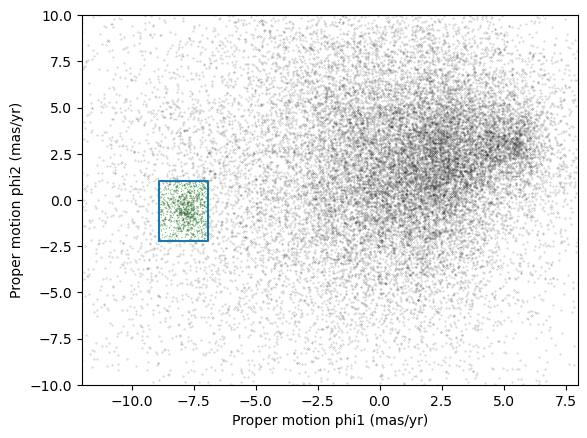

In [4]:
plot_proper_motion(centerline_df)

plt.plot(pm1_rect, pm2_rect)

x = selected_df['pm_phi1']
y = selected_df['pm_phi2']
plt.plot(x, y, 'gx', markersize=0.3, alpha=0.3);

Now we will make the same plot using proper motions in the ICRS frame,
which are stored in columns named `pmra` and `pmdec`.

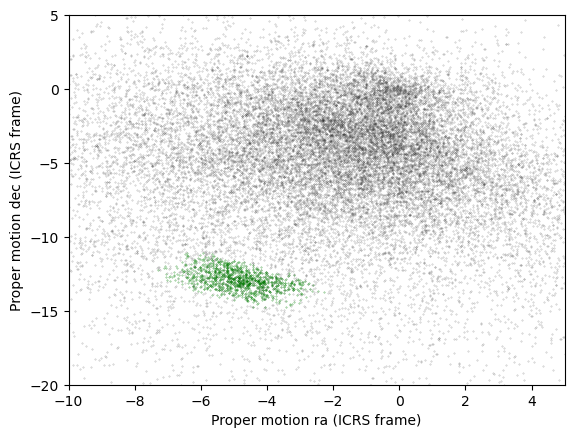

In [5]:
x = centerline_df['pmra']
y = centerline_df['pmdec']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

x = selected_df['pmra']
y = selected_df['pmdec']
plt.plot(x, y, 'gx', markersize=1, alpha=0.3)
    
plt.xlabel('Proper motion ra (ICRS frame)')
plt.ylabel('Proper motion dec (ICRS frame)')

plt.xlim([-10, 5])
plt.ylim([-20, 5]);

The proper motions of the selected stars are more spread out in this
frame, which is why it was preferable to do the selection in the GD-1
frame.

In the following exercise, we will identify a rectangle that encompasses the majority of the stars we identified as having proper motion consistent with that of GD-1 without including too many other stars.

## <p style="background-color: #f5df18; padding: 10px;"> 🛑 Exercise (5 Minutes) </p>

Looking at the proper motion of the stars we identified along the centerline of GD-1, in the ICRS reference frame
define a rectangle (`pmra_min`, `pmra_max`, `pmdec_min`, and `pmdec_max`)
that encompass the proper motion of the majority of the stars near the centerline of GD-1 without including to much contamination from other stars.


In [25]:
pmra_min = -6.70
pmra_max = -3
pmdec_min = -14.31
pmdec_max = -11.2

## Assembling the query
---

In lesson 2 we used the following query to select stars in a polygonal region
around a small part of GD-1 with a few filters on color and distance (parallax):

```python
candidate_coord_query_base = """SELECT
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON({sky_point_list}))
"""
```

In [15]:
candidate_coord_query_base = """SELECT
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON({sky_point_list}))
"""

In this episode we will make two changes:

1. We will select stars with coordinates in a larger region to include more of GD-1.

2. We will add another clause to select stars whose proper motion is in
  the range we just defined in the previous exercise.

The fact that we remove most contaminating stars with the proper
motion filter is what allows us to expand our query to include
most of GD-1 without returning too many results.
As we did in episode 2, we will define the physical region we want
to select in the GD-1 frame and transform it to the ICRS frame
to query the Gaia catalog which is in the ICRS frame.

Here are the coordinates of the larger rectangle in the GD-1 frame.

In [6]:
phi1_min = -70 * u.degree
phi1_max = -20 * u.degree
phi2_min = -5 * u.degree
phi2_max = 5 * u.degree

We selected these bounds by trial and error, defining the largest
region we can process in a single query.

In [7]:
phi1_rect, phi2_rect = make_rectangle(
    phi1_min, phi1_max, phi2_min, phi2_max)

Here is how we transform it to ICRS, as we saw in lesson 2.

In [8]:
corners = SkyCoord(phi1=phi1_rect, 
                   phi2=phi2_rect, 
                   frame=gd1_frame)

corners_icrs = corners.transform_to('icrs')

To use `corners_icrs` as part of an ADQL query, we have to convert it
to a string.
Fortunately, we wrote a function, `skycoord_to_string` to do this in episode 2
which we will call now.

In [11]:
sky_point_list = skycoord_to_string(corners_icrs)

In [12]:
sky_point_list

'135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862'

Here are the columns we want to select.

In [13]:
columns = 'source_id, ra, dec, pmra, pmdec'

Now we have everything we need to assemble the query, but
**DO NOT try to run this query**.
Because it selects a larger region, there are too many stars to handle
in a single query. Until we select by proper motion, that is.

In [17]:
candidate_coord_query = candidate_coord_query_base.format(columns=columns, 
                            sky_point_list=sky_point_list)

In [18]:
print(candidate_coord_query)

SELECT
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))



## Selecting proper motion
---

Now we are ready to add a `WHERE` clause to select stars whose proper
motion falls range we defined in the last exercise.

## <p style="background-color: #f5df18; padding: 10px;"> 🛑 Exercise (10 Minutes) </p>
---

Define `candidate_coord_pm_query_base`, starting with `candidate_coord_query_base` and adding two new `BETWEEN`
clauses to select stars whose coordinates of proper motion, `pmra` and
`pmdec`, fall within the region defined by `pmra_min`, `pmra_max`, `pmdec_min`, and `pmdec_max`.
In the next exercise we will use the format statement to fill in the values we defined above.

In [23]:
candidate_coord_pm_query_base = """SELECT 
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON({sky_point_list}))
  AND pmra BETWEEN {pmra_min} AND  {pmra_max}
  AND pmdec BETWEEN {pmdec_min} AND {pmdec_max}
"""

## <p style="background-color: #f5df18; padding: 10px;"> 🛑 Exercise (5 Minutes) </p>
---

Use `format` to format `candidate_coord_pm_query_base` and define `candidate_coord_pm_query`, filling in
the values of `columns`, `sky_point_list`, and `pmra_min`, `pmra_max`, `pmdec_min`, `pmdec_max`.

In [26]:
candidate_coord_pm_query = candidate_coord_pm_query_base.format(columns=columns, 
                            sky_point_list=sky_point_list,
                            pmra_min=pmra_min,
                            pmra_max=pmra_max,
                            pmdec_min=pmdec_min,
                            pmdec_max=pmdec_max)
print(candidate_coord_pm_query)

SELECT 
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))
  AND pmra BETWEEN -6.7 AND  -3
  AND pmdec BETWEEN -14.31 AND -11.2



Now we can run the query like this:

In [27]:
candidate_coord_pm_job = Gaia.launch_job_async(candidate_coord_pm_query)

INFO: Query finished. [astroquery.utils.tap.core]


In [28]:
print(candidate_coord_pm_job)

<Table length=8409>
   name    dtype    unit                              description                            
--------- ------- -------- ------------------------------------------------------------------
SOURCE_ID   int64          Unique source identifier (unique within a particular Data Release)
       ra float64      deg                                                    Right ascension
      dec float64      deg                                                        Declination
     pmra float64 mas / yr                         Proper motion in right ascension direction
    pmdec float64 mas / yr                             Proper motion in declination direction
Jobid: 1717134366717O
Phase: COMPLETED
Owner: None
Output file: async_20240530224606.vot
Results: None


And get the results.

In [29]:
candidate_gaia_table = candidate_coord_pm_job.get_results()

In [30]:
len(candidate_gaia_table)

8409

## 🔔 BETWEEN vs POLYGON
---

You may be wondering why we used `BETWEEN` for proper motion when we previously used `POLYGON`
for coordinates. ADQL intends the `POLYGON` function to only be used on coordinates and not on proper motion.
To enforce this, it will produce an error when a negative value is passed into the first argument.

We call the results `candidate_gaia_table` because it contains information from
the Gaia table for stars that are good candidates for GD-1.

`sky_point_list`, `pmra_min`, `pmra_max`, `pmdec_min`, and `pmdec_max` are a set of selection criteria that we
derived from data downloaded from the Gaia Database. To make sure we can repeat
our analysis at a later date we should save this information to a file.

There are several ways we could do that, but since we are already
storing data in an HDF5 file, we will do the same with these variables.

To save them to an HDF5 file we first need to put them in a Pandas object.
We have seen how to create a `Series` from a column in a `DataFrame`.
Now we will build a `Series` from scratch.
We do not need the full `DataFrame` format with multiple rows and columns
because we are only storing one string (`sky_point_list`).
We can store each string as a row in the `Series` and save it. One aspect that
is nice about `Series` is that we can label each row.
To do this we need an object that can define both the name of each row and
the data to go in that row. We can use a Python `Dictionary` for this,
defining the row names with the dictionary keys and the row data with
the dictionary values.

In [31]:
d = dict(sky_point_list=sky_point_list, pmra_min=pmra_min, pmra_max=pmra_max, pmdec_min=pmdec_min, pmdec_max=pmdec_max)
d

{'sky_point_list': '135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862',
 'pmra_min': -6.7,
 'pmra_max': -3,
 'pmdec_min': -14.31,
 'pmdec_max': -11.2}

And use this `Dictionary` to initialize a `Series`.

In [32]:
point_series = pd.Series(d)
point_series

sky_point_list    135.306, 8.39862, 126.51, 13.4449, 163.017, 54...
pmra_min                                                       -6.7
pmra_max                                                         -3
pmdec_min                                                    -14.31
pmdec_max                                                     -11.2
dtype: object

Now we can save our `Series` using `to_hdf()`.

In [34]:
filename = 'gd1_data.hdf'
point_series.to_hdf(path_or_buf=filename, key='point_series')

/var/folders/b3/gxd2jb0s4bq1wknd7l1bnpg80000gn/T/ipykernel_15395/2686490738.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  point_series.to_hdf(path_or_buf=filename, key='point_series')


## 🔔 Performance Warning
---

You may see the previous command issue this or a similar performance warning:

```output
[...] PerformanceWarning:
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]
  point_series.to_hdf(filename, 'point_series')
```

This is because in the Series we just created, we are mixing variables of
different types: `sky_point_list` is a string (text), whereas `pmra_min`
etc. are floating point numbers. While combining different data types in a
single Series is somewhat inefficient, the amount of data is small enough to
not matter in this case, so this warning can be safely ignored.

## Plotting one more time
---

Now we can examine the results:

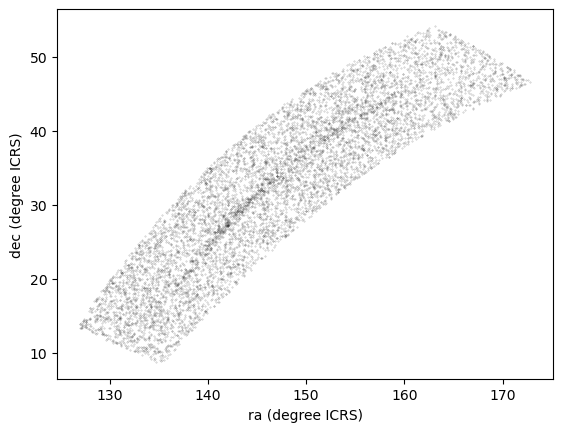

In [35]:
x = candidate_gaia_table['ra']
y = candidate_gaia_table['dec']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)');

This plot shows why it was useful to transform these coordinates to the GD-1 frame.  In
ICRS, it is more difficult to identity the stars near the centerline
of GD-1.

We can use our `make_dataframe` function from episode 3 to transform the results back
to the GD-1 frame. In addition to doing the coordinate transformation and reflex correction
for us, this function also compiles everything into a single object (a `DataFrame`) to make it easier to use. Note that because we put this code into a function, we can do all of this with a single line of code!

In [40]:
candidate_gaia_df = make_dataframe(candidate_gaia_table)

We can check the results using the `plot_pm_selection` function we wrote in lesson 3

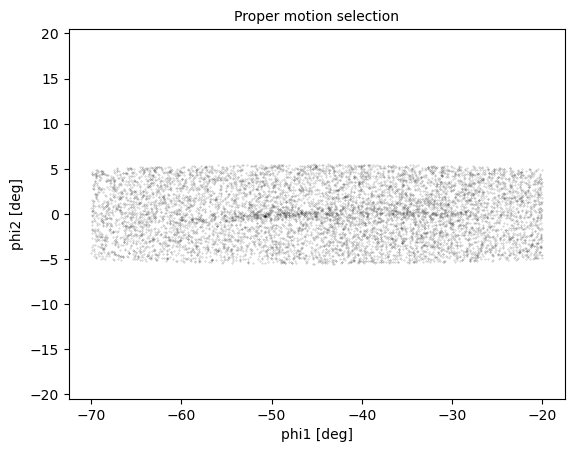

In [41]:
plot_pm_selection(candidate_gaia_df)

We are starting to see GD-1 more clearly.
We can compare this figure with this panel from Figure 1 from the
original paper:

<img height="150"
src="https://datacarpentry.org/astronomy-python/fig/gd1-2.png" alt="Figure from Price-Whelan and Bonaca paper showing phi1 vs phi2 in GD-1 after selecting on proper motion.">

This panel shows stars selected based on proper motion only, so it is
comparable to our figure (although notice that the original figure covers a wider
region).

In the next episode, we will use photometry data from Pan-STARRS to do
a second round of filtering, and see if we can replicate this panel.

<img height="150"
src="https://datacarpentry.org/astronomy-python/fig/gd1-4.png" alt="Figure from Price-Whelan and Bonaca paper showing phi1 vs phi2 in GD-1 after selecting on proper motion and photometry.">

Later we will learn how to add annotations like the ones in the figure and
customize the style of the figure to present the results clearly and
compellingly.

# Summary

---

In the previous episode we downloaded data for a large number of stars
and then selected a small fraction of them based on proper motion.

In this episode, we improved this process by writing a more complex
query that uses the database to select stars based on proper motion.
This process requires more computation on the Gaia server, but then
we are able to either:

1. Search the same region and download less data, or

2. Search a larger region while still downloading a manageable amount of data.

In the next episode, we will learn about the database `JOIN` operation, which we will use
in later episodes to join our Gaia data with photometry data from Pan-STARRS.

# <p style="background-color: #f5df18; padding: 10px;"> 🗝️ Key points</p>

---

- When possible, 'move the computation to the data'; that is, do as much of the work as possible on the database server before downloading the data.